In [79]:
# Libraries used
!pip install hmmlearn



import warnings
warnings.filterwarnings("ignore")
import pandas as pd, numpy as np
from hmmlearn.hmm import GaussianHMM

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Preparing the Data
##### Dataset available at https://github.com/sergiuoprea/Hand-Gesture-Recognition-Datasets

In [80]:
def load_data(dataset_fname, col_names_prefix=None):

    if col_names_prefix is None:
        col_names_prefix = ['LC_X', 'LC_Y', 'RC_X', 'RC_Y']
    
    try:
        raw_data = pd.read_csv(dataset_fname)
    except FileNotFoundError:
        print(f'File not found at {dataset_fname}')
        return None, None
        
    list_data = []
    for prefix in col_names_prefix:
        list_cols = [f"{prefix}_{idx}" for idx in range(1,31)]
        list_data.append(raw_data[list_cols].to_numpy())
    data = np.stack(list_data, axis=2)
    labels = raw_data['Gesture'].to_numpy()
    
    return data, labels

In [81]:
# Load Data
data, labels = load_data('./Original_Dataset.csv')

In [82]:
def train_test_split(gesture, test_percent=0.2, split_type='random'):
    if split_type == 'random':
        idx_gesture = np.where(labels==gesture)[0].tolist()
        data_gesture = data[idx_gesture]
        
        np.random.shuffle(idx_gesture)
        idx_test_split = int(test_percent*len(idx_gesture))
        test_data = data[idx_gesture[:idx_test_split]]
        train_data = data[idx_gesture[idx_test_split:]]
    else:
        print(f'split_type not implemented: {split_type}')
    return train_data, test_data

In [83]:
# Split to train and test samples
train_data, test_data = train_test_split(labels[0])

In [84]:
train_data.shape, test_data.shape

((40, 30, 4), (10, 30, 4))

## Normalizing the Data

In [85]:
def normalize_data(arr):
    norm_arr = np.copy(arr).astype(np.float64)
    for idx in range(len(arr)):
        norm_arr[idx] = (arr[idx]-arr[idx].min(axis=0))/(arr[idx].max(axis=0) - arr[idx].min(axis=0))
    return np.nan_to_num(norm_arr)

In [86]:
train_normalized = normalize_data(train_data)

## Building the Model 

In [87]:
dict_models = {}
dict_data = {}
for label in np.unique(labels):
    # prepare data
    train_data, test_data = train_test_split(label)
    train_data = normalize_data(train_data)
    test_data = normalize_data(test_data)
    # build model
    model = GaussianHMM(n_components=2)
    model.fit(train_data.reshape(-1,4), lengths=[30]*40)
    dict_models[label] = model
    dict_data[label] = (train_data, test_data)

In [88]:
dict_models

{'MoveDown': GaussianHMM(n_components=2),
 'MoveLeft': GaussianHMM(n_components=2),
 'MoveRight': GaussianHMM(n_components=2),
 'MoveUp': GaussianHMM(n_components=2),
 'Press': GaussianHMM(n_components=2),
 'ZoomIn': GaussianHMM(n_components=2),
 'ZoomOut': GaussianHMM(n_components=2)}

## Evaluating the Test Data

In [89]:
for label in np.unique(labels):
    train_data, test_data = dict_data[label]
    
    res = []
    # predict score for all models
    for lab in labels:
        model = dict_models[lab]
        res.append(model.score(test_data.reshape(-1,4)))
    # find the best model based on the score.
    print(f"For Gesture {label}, prediction is {labels[np.argmax(res)]}.")

For Gesture MoveDown, prediction is MoveDown.
For Gesture MoveLeft, prediction is MoveLeft.
For Gesture MoveRight, prediction is MoveRight.
For Gesture MoveUp, prediction is MoveUp.
For Gesture Press, prediction is Press.
For Gesture ZoomIn, prediction is ZoomIn.
For Gesture ZoomOut, prediction is ZoomOut.


## Finding the Best Configuration

In [90]:
results_df = pd.DataFrame()

for components in range(2, 11):
    for label in np.unique(labels):
        temp_model = GaussianHMM(n_components=components)
        train_data, test_data = dict_data[label]
        temp_model.fit(train_data.reshape(-1,4), lengths=[30]*40)
        model_score = temp_model.score(test_data.reshape(-1,4))
        results_df = results_df.append(pd.DataFrame(data={"Gesture": [label], "Num_components": [components], 
                                                          "Score": [model_score]}), ignore_index=True)

In [91]:
print("\n\nScores for different number of components in HMM model")
results_df.pivot_table(index='Gesture', columns="Num_components", values='Score', aggfunc=np.sum).apply(round)



Scores for different number of components in HMM model


Num_components,2,3,4,5,6,7,8,9,10
Gesture,,,,,,,,,
MoveDown,2719.0,2847.0,2754.0,2611.0,2567.0,2550.0,2485.0,2469.0,2502.0
MoveLeft,2771.0,2763.0,2758.0,2772.0,2734.0,2725.0,2701.0,2704.0,2711.0
MoveRight,2840.0,2916.0,2894.0,2862.0,2862.0,2867.0,2836.0,2847.0,2818.0
MoveUp,2823.0,2555.0,2427.0,2296.0,2312.0,2108.0,1986.0,1822.0,1809.0
Press,2631.0,2598.0,2555.0,2550.0,2543.0,2538.0,2542.0,2538.0,2532.0
ZoomIn,28.0,224.0,64.0,236.0,107.0,101.0,69.0,113.0,110.0
ZoomOut,135.0,350.0,276.0,441.0,471.0,443.0,456.0,419.0,525.0


In [92]:
# Best model
final_results_df = results_df.sort_values("Score", ascending=False).groupby("Gesture").first().reset_index()
final_results_df

,Gesture,Num_components,Score
0,MoveDown,3,2846.814807
1,MoveLeft,5,2771.929562
2,MoveRight,3,2916.100484
3,MoveUp,2,2822.805146
4,Press,2,2630.529941
5,ZoomIn,5,235.740916
6,ZoomOut,10,525.051797


## Sampling from the HMM

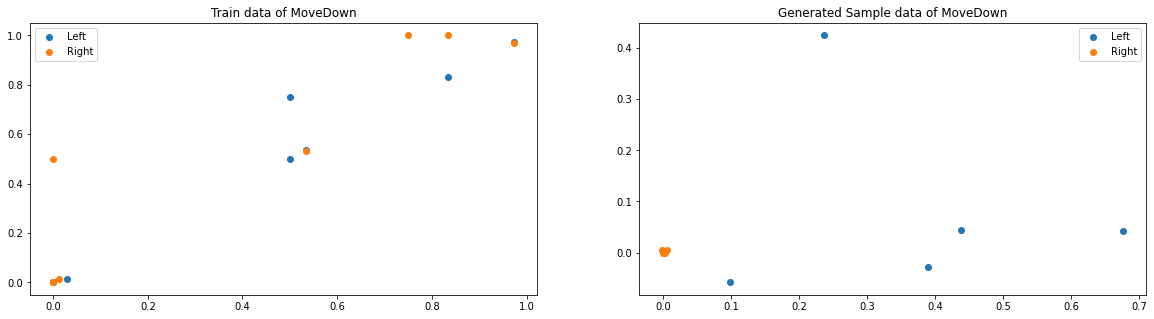

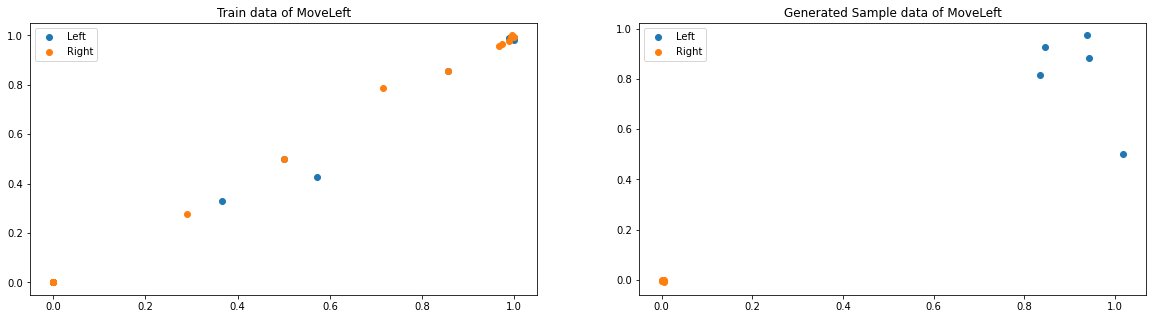

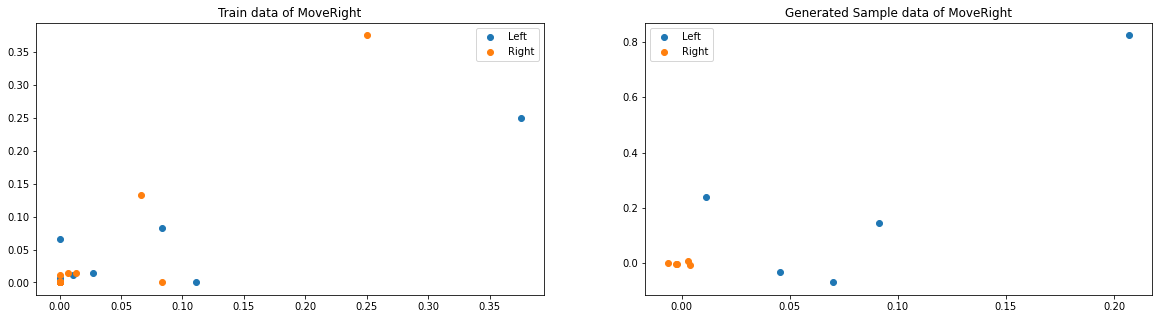

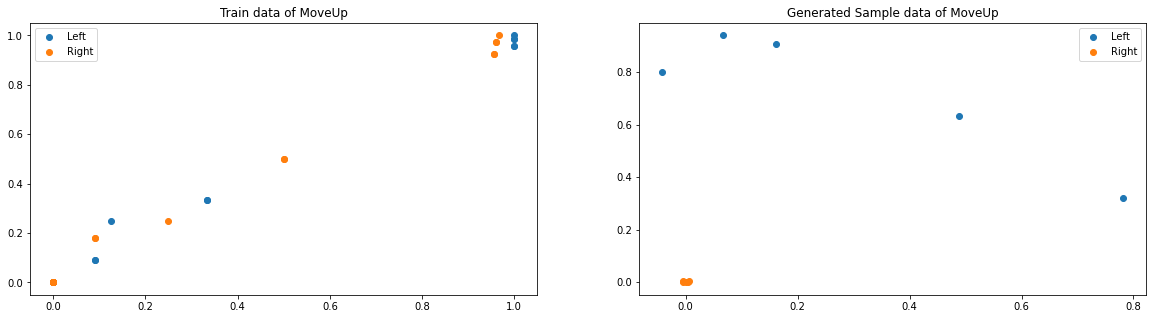

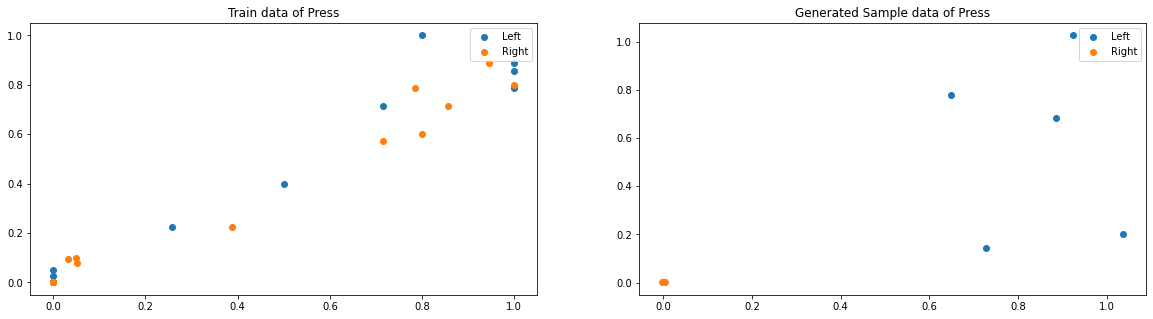

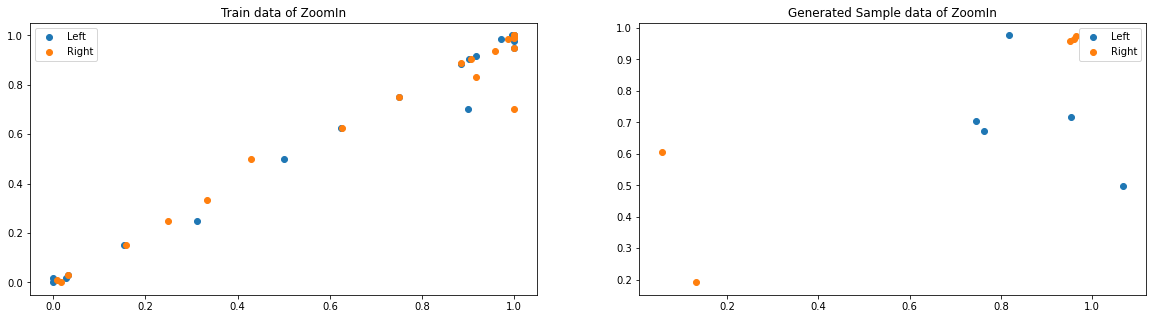

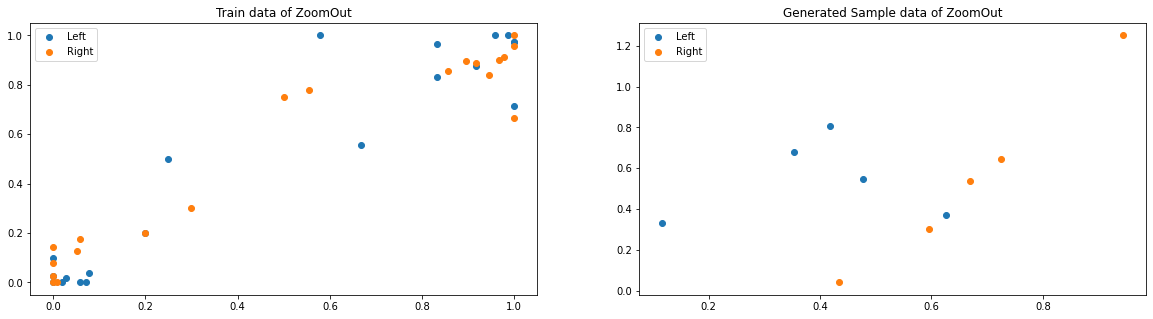

In [93]:
import matplotlib.pyplot as plt
def plot_sample(r, title="Sample", ax=None):
    if ax:
        ax.scatter(x=r[:,0],y=r[:,1])
        ax.scatter(x=r[:,2],y=r[:,3])
        ax.legend(["Left", "Right"])
        ax.set_title(title)
        #plt.show()
    else:
        fig = plt.figure(figsize=(10,5))
        plt.scatter(x=r[:,0],y=r[:,1])
        plt.scatter(x=r[:,2],y=r[:,3])
        plt.legend(["Left", "Right"])
        plt.title(title)
        plt.show()
    
r = model.sample(4)[0]

dict_best_model = {}

for i, row in final_results_df.iterrows():
    gesture, components = row['Gesture'], row['Num_components']
    temp_model = GaussianHMM(n_components=components)
    train_data, test_data = dict_data[gesture]
    temp_model.fit(train_data.reshape(-1,4), lengths=[30]*40)
    
    dict_best_model[gesture] = temp_model
    
    fig, ax = plt.subplots(figsize=(20,5), nrows=1,ncols=2)
    plot_sample(train_data[np.random.randint(0,40,5), :], title=f"Train data of {gesture}", ax=ax[0])
    plot_sample(temp_model.sample(5)[0], title=f"Generated Sample data of {gesture}", ax=ax[1])
    plt.show()


## Comparing Samples

## The Forwards Algorithm

In [94]:
dict_best_model['MoveDown'].get_params()

{'algorithm': 'viterbi',
 'covariance_type': 'diag',
 'covars_prior': 0.01,
 'covars_weight': 1,
 'implementation': 'log',
 'init_params': 'stmc',
 'means_prior': 0,
 'means_weight': 0,
 'min_covar': 0.001,
 'n_components': 3,
 'n_iter': 10,
 'params': 'stmc',
 'random_state': None,
 'startprob_prior': 1.0,
 'tol': 0.01,
 'transmat_prior': 1.0,
 'verbose': False}

In [95]:
for gesture, model in dict_best_model.items():
    
    train_data, test_data = train_test_split(gesture)
    test_data = normalize_data(test_data)
    train_data = normalize_data(train_data)
    model.fit(train_data.reshape(-1,4), lengths=[30]*40)
    model_score = model.score(test_data.reshape(-1,4))
    
    forward_model = GaussianHMM(init_params=model.get_params())
    forward_model.fit(train_data.reshape(-1,4), lengths=[30]*40)
    forward_model_score = forward_model.score(test_data.reshape(-1,4))
    print(f"Gesture: {gesture}, Score on test (Trained Model): {model_score}, Score on test (Forward Parameters): {forward_model_score}")

Gesture: MoveDown, Score on test (Trained Model): 2832.060483985481, Score on test (Forward Parameters): 2734.419463981111


Gesture: MoveLeft, Score on test (Trained Model): 2842.0575027742952, Score on test (Forward Parameters): 2789.3447117256537


Gesture: MoveRight, Score on test (Trained Model): 2807.3327996541857, Score on test (Forward Parameters): 2766.9620045819856


Gesture: MoveUp, Score on test (Trained Model): 2724.617287464299, Score on test (Forward Parameters): 2714.3796993221363


Gesture: Press, Score on test (Trained Model): 2714.3417087312237, Score on test (Forward Parameters): 2759.4905433429803


Gesture: ZoomIn, Score on test (Trained Model): 351.920831548877, Score on test (Forward Parameters): -611.1271678717831
Gesture: ZoomOut, Score on test (Trained Model): 469.0545938575895, Score on test (Forward Parameters): -431.516170193565
